# Sales Project

In [639]:
# to extract the data set from a compressed(zipped file)
#import zipfile
#zip_ref = zipfile.ZipFile('1-sales dataset.zip')
#zip_ref.extractall()
#zip_ref.close()

In [640]:
import pandas as pd
import numpy as np


In [641]:
df=pd.read_csv(r"C:\Users\Amir\Dropbox\Workshop\Python\Sales Project\Amazon Sale Report.csv")

In [642]:
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,Courier Status,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by,New,PendingS
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,T-shirt,S,On the Way,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,False,Easy Ship,NaN,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,Shirt,3XL,Shipped,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,False,Easy Ship,NaN,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Shirt,XL,Shipped,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,True,NaN,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,Blazzer,L,On the Way,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,False,Easy Ship,NaN,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Trousers,3XL,Shipped,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,False,NaN,NaN,NaN


## Data Cleaning

As we don't have any data available and these two columns, 'New' & 'PendingS', are completely empty, we can drop them from our dataset.

In [643]:
df = df.drop(['New', 'PendingS'], axis=1)
df = df.drop(['index'], axis=1)
df.columns

Index(['Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel',
       'ship-service-level', 'Category', 'Size', 'Courier Status', 'Qty',
       'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code',
       'ship-country', 'B2B', 'fulfilled-by'],
      dtype='object')

I want to replace spaces (' ') and hyphens ('-') with underscores ('_') across the entire DataFrame.

### String Manipulation:


In [644]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('-', '_')
df.columns

Index(['Order_ID', 'Date', 'Status', 'Fulfilment', 'Sales_Channel',
       'ship_service_level', 'Category', 'Size', 'Courier_Status', 'Qty',
       'currency', 'Amount', 'ship_city', 'ship_state', 'ship_postal_code',
       'ship_country', 'B2B', 'fulfilled_by'],
      dtype='object')

###  Missing Values

In [645]:

df.isnull().sum()

Order_ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales_Channel             0
ship_service_level        0
Category                  0
Size                      0
Courier_Status            0
Qty                       0
currency               7800
Amount                 7800
ship_city                35
ship_state               35
ship_postal_code         35
ship_country             35
B2B                       0
fulfilled_by          89713
dtype: int64

Notice, in dataset provided:
- The 'currency' column contains only one unique value: "INR"
- The 'ship_country' also contains only one unique value: "IN"
- The 'Amount' column is missing whenever 'Courier_Status' is 'Cancelled', 'Unshipped', or 'On the Way'.

In [646]:
df['currency'] = df['currency'].fillna('INR')
df['ship_country'] = df['ship_country'].fillna('IN')

In [647]:
# replace 'Amount' column with 0 whenever the condition below for 'Courier_Status' is met.
df.loc[
    (df['Amount'].isna()) &
    (df['Courier_Status'].isin(['Cancelled', 'Unshipped', 'On the Way'])),
    'Amount'
] = 0


In [648]:
print(df[['currency', 'ship_country', 'Amount']].isnull().sum())

currency        0
ship_country    0
Amount          0
dtype: int64


In [649]:
df[
    (df['Amount'] == 0) &
    (df['Courier_Status'] == 'Shipped')
].shape[0]

2317

We notice that we have few data where Amount is 0, even if the Courier is shipped. I assume it might be because of various reasons, such as:
- data entry errors
- free items or promotional shipments
- failed price calculation logic
- corrupt source data

In [650]:
df.isnull().sum()

Order_ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales_Channel             0
ship_service_level        0
Category                  0
Size                      0
Courier_Status            0
Qty                       0
currency                  0
Amount                    0
ship_city                35
ship_state               35
ship_postal_code         35
ship_country              0
B2B                       0
fulfilled_by          89713
dtype: int64

In [651]:
most_common = df[['ship_city','ship_state','ship_postal_code']].value_counts()
print(most_common)

ship_city    ship_state         ship_postal_code
NOIDA        UTTAR PRADESH      201301.0            823
GURUGRAM     HARYANA            122001.0            550
BENGALURU    KARNATAKA          560037.0            532
                                560068.0            524
                                560076.0            458
                                                   ... 
ACHALPUR     MAHARASHTRA        444806.0              1
west bengal  WEST BENGAL        721301.0              1
yavatmal     MAHARASHTRA        445001.0              1
yazali       ARUNACHAL PRADESH  791119.0              1
yellapur     KARNATAKA          581359.0              1
Name: count, Length: 18212, dtype: int64


I believe, replacing each column's missing values independently (e.g., using mode()) can lead to inconsistent combinations, which would be geographically invalid. However, each of these columns are related, and should match. So replacing each column independently using mode() can break that relationship.

Best Practice would be to Impute them together based on mode of valid rows.

In [652]:
triplet_mode = df[['ship_city', 'ship_state', 'ship_postal_code']].mode().iloc[0]

df.fillna({'ship_city': triplet_mode['ship_city']}, inplace= True)
df.fillna({'ship_state': triplet_mode['ship_state']}, inplace= True)
df.fillna({'ship_postal_code': triplet_mode['ship_postal_code']}, inplace= True)

In [653]:
blank_count = df['fulfilled_by'].isna().sum()
print(f"Count of fulfilled_by missing values: {blank_count}")

total_rows = len(df)
blank_percentage = (blank_count/total_rows)*100
print(f"The percentage of 'fulfilled_by' missing values: {blank_percentage:.2f}%")

Count of fulfilled_by missing values: 89713
The percentage of 'fulfilled_by' missing values: 69.56%


The vast majority of orders don't specify a fulfillment method. Only about 30.44% have a value - "Easy Ship". So, we might prefer not to use the mode function but to replace with a placeholder -e.g., "Unknown".

In [654]:
df['fulfilled_by'] = df['fulfilled_by'].fillna('Unknown')

In [655]:
df.isna().sum()

Order_ID              0
Date                  0
Status                0
Fulfilment            0
Sales_Channel         0
ship_service_level    0
Category              0
Size                  0
Courier_Status        0
Qty                   0
currency              0
Amount                0
ship_city             0
ship_state            0
ship_postal_code      0
ship_country          0
B2B                   0
fulfilled_by          0
dtype: int64

In [656]:
df['ship_state'].unique()

array(['MAHARASHTRA', 'KARNATAKA', 'PUDUCHERRY', 'TAMIL NADU',
       'UTTAR PRADESH', 'CHANDIGARH', 'TELANGANA', 'ANDHRA PRADESH',
       'RAJASTHAN', 'DELHI', 'HARYANA', 'ASSAM', 'JHARKHAND',
       'CHHATTISGARH', 'ODISHA', 'KERALA', 'MADHYA PRADESH',
       'WEST BENGAL', 'NAGALAND', 'Gujarat', 'UTTARAKHAND', 'BIHAR',
       'JAMMU & KASHMIR', 'PUNJAB', 'HIMACHAL PRADESH',
       'ARUNACHAL PRADESH', 'Goa', 'MEGHALAYA', 'GOA', 'MANIPUR',
       'TRIPURA', 'LADAKH', 'DADRA AND NAGAR', 'SIKKIM', 'Delhi',
       'ANDAMAN & NICOBAR', 'Punjab', 'Rajshthan', 'Manipur', 'rajasthan',
       'Odisha', 'NL', 'Bihar', 'MIZORAM', 'punjab', 'New Delhi',
       'Rajasthan', 'Punjab/Mohali/Zirakpur', 'Puducherry', 'delhi', 'RJ',
       'Chandigarh', 'orissa', 'LAKSHADWEEP', 'goa', 'PB', 'APO',
       'Arunachal Pradesh', 'AR', 'Pondicherry', 'Sikkim',
       'Arunachal pradesh', 'Nagaland', 'bihar', 'Mizoram', 'rajsthan',
       'Orissa', 'Rajsthan', 'Meghalaya'], dtype=object)

We notice that some states are ripetitive and written in different ways, e.g., 'RJ', 'RAJASTHAN', 'Rajasthan', 'Rajsthan'. Let's replace them with the correct ones.

In [657]:
df['ship_state'] = df['ship_state'].str.title()
df['ship_state'].unique()

array(['Maharashtra', 'Karnataka', 'Puducherry', 'Tamil Nadu',
       'Uttar Pradesh', 'Chandigarh', 'Telangana', 'Andhra Pradesh',
       'Rajasthan', 'Delhi', 'Haryana', 'Assam', 'Jharkhand',
       'Chhattisgarh', 'Odisha', 'Kerala', 'Madhya Pradesh',
       'West Bengal', 'Nagaland', 'Gujarat', 'Uttarakhand', 'Bihar',
       'Jammu & Kashmir', 'Punjab', 'Himachal Pradesh',
       'Arunachal Pradesh', 'Goa', 'Meghalaya', 'Manipur', 'Tripura',
       'Ladakh', 'Dadra And Nagar', 'Sikkim', 'Andaman & Nicobar',
       'Rajshthan', 'Nl', 'Mizoram', 'New Delhi',
       'Punjab/Mohali/Zirakpur', 'Rj', 'Orissa', 'Lakshadweep', 'Pb',
       'Apo', 'Ar', 'Pondicherry', 'Rajsthan'], dtype=object)

In [658]:
state = {'Rajshthan': 'Rajasthan',
    'Rj': 'Rajasthan',
    'Rajsthan': 'Rajasthan',
    'Orissa': 'Odisha',
    'Punjab/Mohali/Zirakpur': 'Punjab',
    'Pb': 'Punjab',
    'Pondicherry': 'Puducherry',
    'Nl': 'Delhi',
    'New Delhi': 'Delhi',
    'Ar': 'Arunachal Pradesh',
    'Dadra And Nagar': 'Dadra and Nagar Haveli and Daman and Diu'
}

In [659]:
df['ship_state'] = df['ship_state'].replace(state)
df['ship_state'].unique()

array(['Maharashtra', 'Karnataka', 'Puducherry', 'Tamil Nadu',
       'Uttar Pradesh', 'Chandigarh', 'Telangana', 'Andhra Pradesh',
       'Rajasthan', 'Delhi', 'Haryana', 'Assam', 'Jharkhand',
       'Chhattisgarh', 'Odisha', 'Kerala', 'Madhya Pradesh',
       'West Bengal', 'Nagaland', 'Gujarat', 'Uttarakhand', 'Bihar',
       'Jammu & Kashmir', 'Punjab', 'Himachal Pradesh',
       'Arunachal Pradesh', 'Goa', 'Meghalaya', 'Manipur', 'Tripura',
       'Ladakh', 'Dadra and Nagar Haveli and Daman and Diu', 'Sikkim',
       'Andaman & Nicobar', 'Mizoram', 'Lakshadweep', 'Apo'], dtype=object)

In [660]:
print(df.duplicated().sum())
print(df[df.duplicated()])

959
                   Order_ID        Date                        Status  \
167     407-3742007-3242711    04-30-22                       Shipped   
201     408-5748499-6859555    04-30-22                       Shipped   
202     406-7807733-3785945    04-30-22  Shipped - Delivered to Buyer   
203     407-5443024-5233168    04-30-22                     Cancelled   
204     402-4393761-0311520    04-30-22                       Shipped   
...                     ...         ...                           ...   
128358  402-3963904-1085913  06-01-2022                     Cancelled   
128373  407-3748395-2933152  06-01-2022                       Shipped   
128496  406-7346635-7865146  06-01-2022                       Shipped   
128909  403-6757403-6097100    05-31-22                     Cancelled   
128954  404-8878574-4524358    05-31-22                       Shipped   

       Fulfilment Sales_Channel ship_service_level Category Size  \
167        Amazon     Amazon.in          Expedited 

The duplicate records are real, valid data. So. we leave them as-is.

## EDA

In [661]:
df.describe(include = ['object'])

,Order_ID,Date,Status,Fulfilment,Sales_Channel,ship_service_level,Category,Size,Courier_Status,currency,ship_city,ship_state,ship_country,fulfilled_by
count,128976,128976,128976,128976,128976,128976,128976,128976,128976,128976,128976,128976,128976,128976
unique,120229,91,13,2,2,2,9,11,4,1,8948,37,1,2
top,403-4984515-8861958,05-03-2022,Shipped,Amazon,Amazon.in,Expedited,T-shirt,M,Shipped,INR,BENGALURU,Maharashtra,IN,Unknown
freq,12,2085,77815,89713,128852,88630,50292,22373,109486,128976,11243,22307,128976,89713


In [678]:
df['Category'].value_counts()

Category
T-shirt     50292
Shirt       49877
Blazzer     15500
Trousers    10616
Perfume      1157
Wallet        926
Socks         440
Shoes         165
Watch           3
Name: count, dtype: int64

In [679]:
df['Sales_Channel'].value_counts()

Sales_Channel
Amazon.in     128852
Non-Amazon       124
Name: count, dtype: int64

In [680]:
df['ship_service_level'].value_counts()

ship_service_level
Expedited    88630
Standard     40346
Name: count, dtype: int64

## Data Visualization

In [662]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

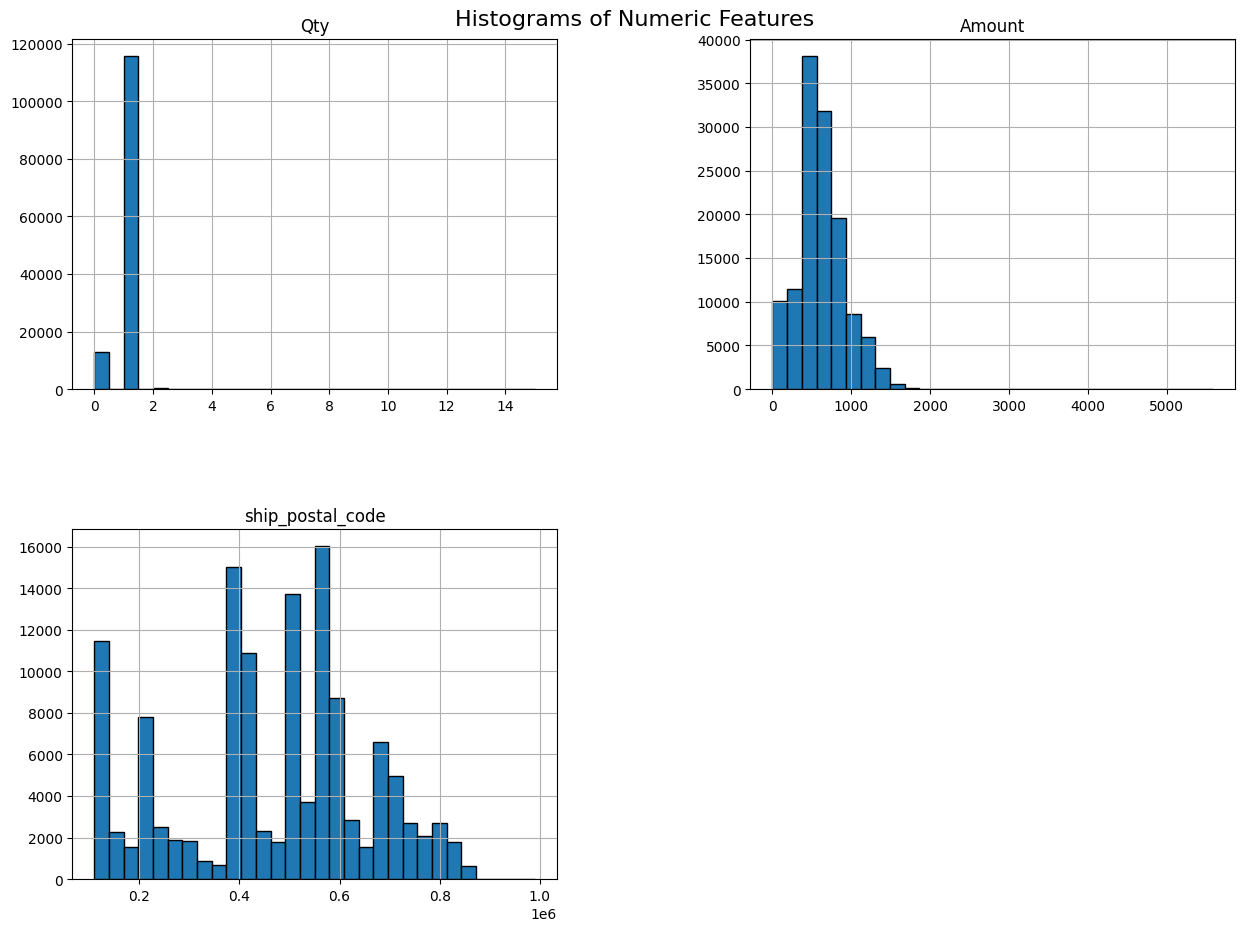

In [663]:
numeric_df = df.select_dtypes(include = ['number'])

numeric_df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Histograms of Numeric Features', fontsize=16)
plt.subplots_adjust(top=0.95, hspace=0.4, wspace=0.4)  # More manual control

plt.show()

In [664]:
numeric_df.describe()

,Qty,Amount,ship_postal_code
count,128976.000000,128976.000000,128976.000000
mean,0.904401,609.339491,463874.404300
std,0.313368,313.342529,191481.383425
min,0.000000,0.000000,110001.000000
25%,1.000000,413.000000,382421.000000
50%,1.000000,583.000000,500033.000000
75%,1.000000,771.000000,600024.000000
max,15.000000,5584.000000,989898.000000


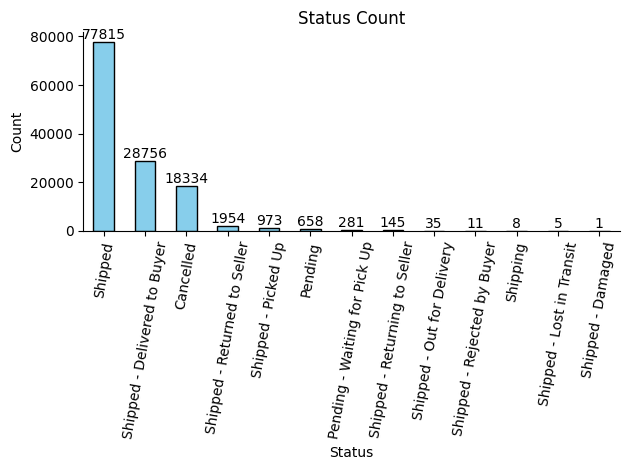

In [676]:
status_counts = df['Status'].value_counts()

ax= status_counts.plot(kind='bar', color= 'skyblue', edgecolor='black')

# Add numbers on bars
for i, count in enumerate(status_counts):
    plt.text(i, count, str(count), ha= 'center', va= 'bottom')

# Remove top and right spines (box lines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# remove grid lines
ax.grid(False)

plt.title('Status Count')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

## Data Filtering: Conditional Filtering

In [665]:
# Count of Expedited Shipments by Category
condition_1 = df[
    df['ship_service_level'] == 'Expedited'
    
    ].groupby('Category').size().reset_index(name='count')

print(condition_1)

   Category  count
0   Blazzer   8456
1   Perfume    835
2     Shirt  35195
3     Shoes    132
4     Socks    244
5   T-shirt  35083
6  Trousers   8002
7    Wallet    680
8     Watch      3


In [666]:
# Count of Merchant Fulfillments by Courier Status
condition_2 = df[
    df['Fulfilment'] == 'Merchant'
    
    ].groupby('Courier_Status').size().reset_index(name='count')

print(condition_2)

  Courier_Status  count
0     On the Way   6870
1        Shipped  31869
2      Unshipped    524


In [667]:
# Filter clothing Category (Trousers), shipped by Amazon, group by Size
condition_3 = df[
    (df['Category'] == 'Trousers') & 
    (df['Fulfilment'] == 'Amazon')

    ].groupby('Size').size().reset_index(name='count')

print(condition_3)

  Size  count
0  3XL    927
1    L   1330
2    M   1352
3    S    923
4   XL   1378
5   XS    772
6  XXL   1385


In [668]:
# Count of Orders Status in selected cities
condition_4 = df[
    
    df['ship_city'].isin(['MUMBAI', 'PUNE', 'AGRA', 'KERALA'])

    ].groupby(['Status', 'ship_city']).size().unstack(fill_value=0)

print(condition_4)

ship_city                      AGRA  MUMBAI  PUNE
Status                                           
Cancelled                        39     747   499
Pending                           0      33    14
Pending - Waiting for Pick Up     1      11     4
Shipped                         123    3843  2407
Shipped - Delivered to Buyer     55    1414   864
Shipped - Out for Delivery        0       2     2
Shipped - Picked Up               2      27    19
Shipped - Rejected by Buyer       0       1     1
Shipped - Returned to Seller      4      42    49
Shipped - Returning to Seller     0       5     4


In [669]:
# Count Orders Cancelled, Amazon & Merchant Fulfillments, group by Size & Fulfillments
condition_5= df[
    (df['Status'] == 'Cancelled') & 
    (df['Fulfilment'].isin(['Amazon', 'Merchant']))

    ].groupby(['Size', 'Fulfilment']).size().unstack(fill_value=0)

print(condition_5)

Fulfilment  Amazon  Merchant
Size                        
3XL           1090       759
4XL             35        13
5XL             38        17
6XL             50        22
Free           167       115
L             1906      1195
M             2056      1273
S             1623       934
XL            1676      1129
XS            1288       560
XXL           1546       842
